In [387]:
# General
import pickle
import pandas as pd
import numpy as np
import math
import datetime
from scipy import stats
import itertools
from pandas.plotting import register_matplotlib_converters
import warnings

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.compose import ColumnTransformer, make_column_selector

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Torch
import torch.nn as nn
import torch
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from tqdm import trange

# Set options
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
warnings.filterwarnings('ignore')

In [388]:
# Load data, sort on zip and date and set index to datetime
with open("../data/sfr_mfr_mig_pre-processed.pkl", "rb") as f: df = pickle.load(f)
df.sort_values(['census_cbsa_geoid', 'census_zcta5_geoid', 'date'], inplace = True)

In [389]:
df.columns

Index(['date', 'census_cbsa_geoid', 'census_zcta5_geoid', 'sfr_rental_index',
       'sfr_price_index', 'coef', 'nounits', 'occupied_units', 'mfr_occ',
       'mfr_mean_occ_index', 'mfr_mean_rent', 'mfr_mean_rent_index', 'month',
       'cos_month', 'sin_month', 'sfr_rental_delta', 'sfr_price_delta',
       'mfr_occ_delta', 'mfr_rental_delta', 'us_zip', 'population',
       'student_population_fraction', 'netflow_estimated', 'inflow_estimated',
       'outflow_estimated', 'cumulative_netflow_estimated',
       'median_income_inflow', 'median_income', 'median_income_difference',
       'median_age_inflow', 'median_age', 'median_age_difference',
       'inflow_index', 'outflow_index', 'netflow_index', 'income_inflow_index',
       'income_diff_index', 'age_inflow_index', 'age_inflow_diff_index'],
      dtype='object')

In [390]:
# subset for time frame that includes MFR data (Jan 2015 - June 2023)
df = df.loc[(df.date >= '2015-01-01') & (df.date <= '2023-06-01')]

In [391]:
# drop incomplete zips
drops = df.loc[df.mfr_occ.isna()].census_zcta5_geoid.unique().tolist()
df.drop(df.loc[df['census_zcta5_geoid'].isin(drops)].index, inplace=True)

In [393]:
# Keep only desired columns
df = df[['date', 'census_zcta5_geoid', 'sfr_rental_delta', 'sfr_price_delta', 
         'mfr_rental_delta', 'mfr_occ_delta', 'cos_month', 'sin_month']]
df

,date,census_zcta5_geoid,sfr_rental_delta,sfr_price_delta,mfr_rental_delta,mfr_occ_delta,cos_month,sin_month
60,2015-01-01,30002,0.0852,-0.3415,0.0000,0.0000,0.8660,0.5000
61,2015-02-01,30002,0.4399,-0.1288,1.5483,0.0000,0.5000,0.8660
62,2015-03-01,30002,0.5385,0.2211,-2.1542,0.2427,0.0000,1.0000
63,2015-04-01,30002,0.4872,0.6915,-0.3801,-0.5663,-0.5000,0.8660
64,2015-05-01,30002,0.8189,1.0205,-1.5642,0.0000,-0.8660,0.5000
...,...,...,...,...,...,...,...,...
36073,2023-02-01,44333,0.8291,-1.3466,1.3648,0.0000,0.5000,0.8660
36074,2023-03-01,44333,0.6817,0.1833,0.7726,-0.2888,0.0000,1.0000
36075,2023-04-01,44333,0.9218,1.0300,0.3216,0.0000,-0.5000,0.8660
36076,2023-05-01,44333,1.3360,1.8028,0.0209,-0.2865,-0.8660,0.5000


In [401]:
array = [3, 4, 5, 6, 7, 8, 9]

print(array[0:3])
print(array[3:6])

[3, 4, 5]
[6, 7, 8]


In [402]:
# Define class

class SFR_DATASET(Dataset):
    def __init__(self, df):
        self.data = df.to_dict('records') # random access is easier with dictionaries
    
    def __len__(self): 
        return len(self.data) - 18  # subtract length of input + output
    
    def __getitem__(self, idx): 
        
        input = pd.DataFrame(self.data[idx:idx+12])
        output = pd.DataFrame(self.data[idx+12:idx+18])
        
        # each of these are 12x1 tensors (12 months of data)
        in_sfr = torch.tensor(input['sfr_rental_delta']) 
        in_sfp = torch.tensor(input['sfr_price_delta'])
        in_mfr = torch.tensor(input['mfr_rental_delta'])
        in_mfo = torch.tensor(input['mfr_occ_delta'])
        in_sinm = torch.tensor(input['sin_month'])
        in_cosm = torch.tensor(input['cos_month']) 
        x = torch.cat((in_sfr, in_sfp, in_mfr, in_mfo, in_sinm, in_cosm), dim = 0) # concat into 72-wide vector
        y = torch.tensor(output['sfr_rental_delta'])
        return {'X':x.float(), 'Y':y.float()}

In [403]:
# Define scaler
scaler = MinMaxScaler(feature_range=(-1, 1))

col_transform = ColumnTransformer(
    transformers=[
        ("num", MinMaxScaler(feature_range=(-1, 1)), make_column_selector(dtype_include=np.number))], 
        remainder='passthrough',
        verbose_feature_names_out = False
)

In [412]:
# Create zip dict to store class for each zip
zip_dict_train = {}
zip_dict_test = {}

# Cast the class, separating out by zipcdoe
for zipcode in df['census_zcta5_geoid'].unique():
    
    # Filter for single zipcode
    zipcode_df = df[df['census_zcta5_geoid'] == zipcode]
    
    # Train test split
    df_train = zipcode_df.loc[(df.date < '2022-01-01')]
    df_test = zipcode_df.loc[(df.date >= '2022-01-01')]
    
    # Transform training data, cast class and store
    train_X = col_transform.fit_transform(df_train)
    train_X = pd.DataFrame(train_X, columns = col_transform.get_feature_names_out())
    train_sfr = SFR_DATASET(train_X)
    zip_dict_train[zipcode] = train_sfr
    
    # Transform testing data, cast class and store
    test_X = col_transform.fit_transform(df_test)
    test_X = pd.DataFrame(test_X, columns = col_transform.get_feature_names_out())
    test_sfr = SFR_DATASET(test_X)
    zip_dict_test[zipcode] = test_sfr

In [413]:
# check contents of dict
print(len(zip_dict_train['30002']))
print(zip_dict_train['30002'][0])

# for given index
# returns X as 1x18 vector (3 months for each of the 6 input variables)
# returns y as 1x6 vecotr (6 month prediction for sfr_rental)

66
{'X': tensor([-1.0000e+00, -7.3362e-01, -6.5953e-01, -6.9805e-01, -4.4901e-01,
        -5.4270e-01, -4.3483e-01, -7.6435e-01, -7.1402e-01, -7.9240e-01,
        -9.2652e-01, -9.0846e-01, -8.0106e-01, -6.4592e-01, -3.9060e-01,
        -4.7322e-02,  1.9270e-01, -4.9943e-01,  5.4419e-01,  8.4357e-01,
         8.7634e-02, -2.1854e-01, -5.0432e-01, -2.8387e-01, -2.6338e-01,
        -9.6415e-02, -4.9568e-01, -3.0436e-01, -4.3206e-01, -3.9460e-01,
        -5.0374e-01,  1.2117e-01, -2.1214e-01, -1.9494e-01, -7.2910e-02,
        -1.2560e-02,  1.2108e-01,  1.2108e-01,  2.9970e-01, -2.9572e-01,
         1.2108e-01,  3.5924e-01, -1.1709e-01,  3.6798e-01,  6.5695e-01,
         2.4016e-01,  1.2108e-01,  2.9970e-01,  5.0000e-01,  8.6603e-01,
         1.0000e+00,  8.6603e-01,  5.0000e-01,  1.2246e-16, -5.0000e-01,
        -8.6603e-01, -1.0000e+00, -8.6603e-01, -5.0000e-01, -2.4493e-16,
         8.6603e-01,  5.0000e-01,  6.1232e-17, -5.0000e-01, -8.6603e-01,
        -1.0000e+00, -8.6603e-01, -5.0000e

In [414]:
# Model: simple multilayer perceptron
# sequential 3 layer model with 1 hidden dim

class SFR_MODEL(nn.Module):
    def __init__(self, indim, hdim, outdim):
        super().__init__() # for nn.MOdule you must initialize the super class
        self.layers = nn.Sequential(
            nn.Linear(indim, hdim),
            nn.LeakyReLU(),
            nn.Linear(hdim, outdim),
            nn.Tanh()
        )
    def forward(self, x):
        return self.layers(x)

In [415]:
# create instance of model

# indim matches length of input vector
# outdim matches length of output vector
# hdim?

model = SFR_MODEL(indim = 72, hdim = 39, outdim = 6)
print(model)

SFR_MODEL(
  (layers): Sequential(
    (0): Linear(in_features=72, out_features=39, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=39, out_features=6, bias=True)
    (3): Tanh()
  )
)


In [416]:
# set up training loop
# optimizer - Adam good to start with
# datalaoder - wrap around dataset to shuffle through batches

opt = Adam(model.parameters())
batchsize = 3
epochs = 150 # go though data 3x
loss_fn = nn.MSELoss()

In [417]:
# Training loop

losses_dict = {} # initialize dict to store loss values for each zip

for zipcode in df['census_zcta5_geoid'].unique():
    
    # Access one zipcdode
    sfr = zip_dict_train[zipcode]
    
    # create dataloader
    dl = DataLoader(sfr, batch_size = batchsize, shuffle = True, drop_last = True)
    
    # initialize list for zip-level losses
    losses = []
    
    for epoch in trange(epochs):
        for batch in dl:
            
            opt.zero_grad() # at the beginning of batch, zero out the optimizer
        
            # use inputs and outputs to make model prediction
            x = batch['X']
            y = batch['Y']
            y_hat = model(x)
        
            loss = loss_fn(y_hat, y) # calculate loss
            loss.backward() # calculate gradient of loss
            opt.step() # runs the optimizer and updates model params based on gradient
            losses.append(loss.cpu().detach().numpy()) # single value as a numpy
            
    losses_dict[zipcode] = losses

100%|██████████████████████████████████████████████████| 150/150 [00:59<00:00,  2.52it/s]


100%|██████████████████████████████████████████████████| 150/150 [00:20<00:00,  7.37it/s]


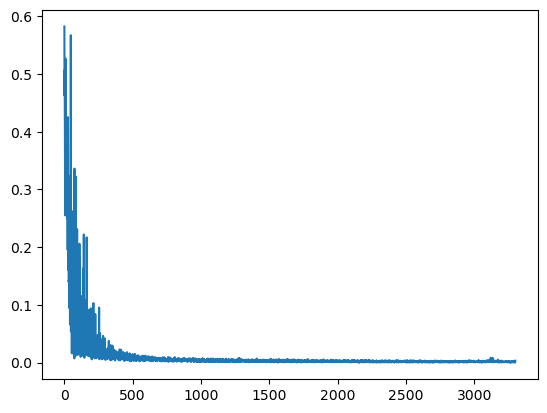

In [420]:
# plot decreasing loss for one zip
plt.plot(np.array(losses_dict['30002']))

In [ ]:
# this is all a work in progress and copied code...nothing running yet

In [ ]:
# fitting the model

training_losses_dict = {} # initialize dict to store loss values for each zip

for zipcode in df['census_zcta5_geoid'].unique():
    
    # Access one zipcdode
    sfr = zip_dict_train[zipcode]
    
    # create dataloader
    dl = DataLoader(sfr, batch_size = batchsize, shuffle = True, drop_last = True)
    
    # initialize list for zip-level training losses
    losses = []
    
    # training loop
    
    for epoch in trange(epochs):
        for batch in dl:
            
            opt.zero_grad() # at the beginning of batch, zero out the optimizer
        
            # use inputs and outputs to make model prediction
            x = batch['X']
            y = batch['Y']
            y_hat = model(x)
        
            loss = loss_fn(y_hat, y) # calculate loss
            loss.backward() # calculate gradient of loss
            opt.step() # runs the optimizer and updates model params based on gradient
            losses.append(loss.cpu().detach().numpy()) # single value as a numpy
         
    training_losses_dict[zipcode] = losses

    # Test loop
    
    model = model.cpu()
    model.eval()
    
    with torch.no_grad():
        for example in xor_dataset:
            x = example['x']
            y = example['y']
            y_hat = model(x)
            loss = loss_fn(y_hat, y)
            print('x:', x, 'y:', y, 'y_hat:', y_hat, 'loss:', loss)

In [ ]:
output = pd.DataFrame(columns = ['zip', 'model', 'mape', 'mae', 'mse'])

In [ ]:
    output_zip = []
    output_zip.append(zipcode)
    output_zip.append('nn_batch3_epoch150')
    output_zip.append(performance_metrics(df_cv)['mape'].mean())
    output_zip.append(performance_metrics(df_cv)['mae'].mean())
    output_zip.append(performance_metrics(df_cv)['mse'].mean())
    output.loc[len(output)] = output_zip

In [ ]:
# from Cole's example code
model = model.cpu()
model.eval()

with torch.no_grad():
    for example in xor_dataset:
        x = example['x']
        y = example['y']
        y_hat = model(x)
        loss = loss_fn(y_hat, y)
        print('x:', x, 'y:', y, 'y_hat:', y_hat, 'loss:', loss)

In [ ]:
# from https://theaveragecoder.medium.com/training-and-testing-a-basic-neural-network-using-pytorch-4010300fda45

test_loss = 0.0
correct, total = 0,0

for data,label in testloader:
    if is_gpu:
        data, label = data.cuda(), label.cuda()
    output = model(data)
    for o,l in zip(torch.argmax(output,axis = 1),label):
        if o == l:
            correct += 1
        total += 1
    loss = criterion(output,label)
    test_loss += loss.item() * data.size(0)
print(f'Testing Loss:{test_loss/len(testloader)}')
print(f'Correct Predictions: {correct}/{total}')